In [52]:
%pip install pykeen
%pip install torch
%pip install numpy==1.26.4
# %pip install cuda
%pip install matplotlib
# %pip install torch==2.3.0+cu121 torchvision torchaudio
# %pip install --upgrade pip
%pip install pykeen
%pip install rdflib
%pip list

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.3/730.3 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 13.0 MB/s eta 0:00:00
Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.8.1
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.1
alembic                               1.16.2
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz          

In [53]:
#### Parsing the Knowledge graph

import rdflib
import numpy as np
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
import os

rdf_graph = rdflib.Graph()

KG_Path = "/content/100_patients.ttl"
rdf_graph.parse(KG_Path, format="ttl")

print(f"✅ Loaded {len(rdf_graph):,} triples")

INFO:pykeen.utils:Using opt_einsum


✅ Loaded 7,192,283 triples


In [ ]:
#### Creating the triples factory

tf = TriplesFactory.from_labeled_triples(np.array([(str(s), str(p), str(o)) for s, p, o in rdf_graph], dtype=object))

In [ ]:
tf.mapped_triples.shape

torch.Size([7192283, 3])

In [ ]:
%pip install torch

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
#### Init the model

from pykeen.models import TransE
from torch.optim import Adam
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm


embed_dim = 100
model = TransE(triples_factory = tf, embedding_dim=embed_dim)
model.to("cuda")

model.train(mode = True)

batch_size = 1024
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = model.loss

num_triples = tf.mapped_triples.shape[0]
num_batches = (num_triples + batch_size -1 ) // batch_size

num_epochs = 10
avg_losses = []

for epoch in tqdm(range(num_epochs),desc = "Epochs"):
  epoch_loss = 0.0
  for batch_idx in range(num_batches):
      start = batch_idx * batch_size
      end = min(start + batch_size, num_triples)
      positive_batch = tf.mapped_triples[start:end]
      optimizer.zero_grad()
      scores = model.score_hrt(positive_batch)
      loss = loss_fn(scores, torch.ones_like(scores))
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
  avg_loss = epoch_loss / num_batches
  avg_losses.append(avg_loss)

def plot_avg_losses(avg_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(avg_losses) + 1), avg_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Average Loss per Epoch')
    plt.grid(True)
    plt.show()





INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
Epochs: 100%|██████████| 10/10 [1:04:46<00:00, 388.62s/it]


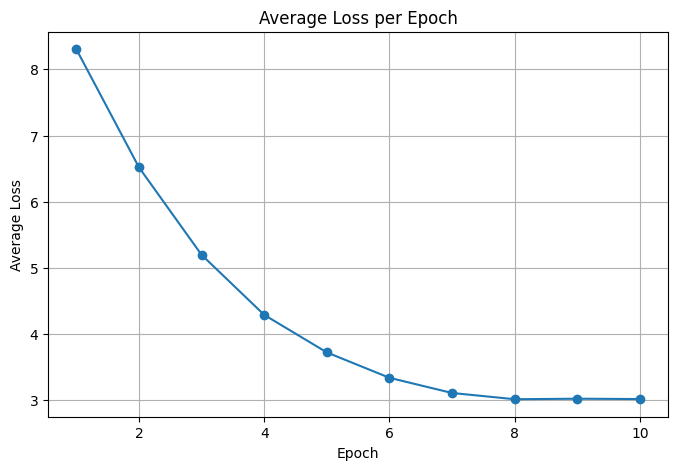

In [ ]:
plot_avg_losses(avg_losses)

In [ ]:
# Save the model
model_path = "TransE_model_10epochs_dim100.pt"
torch.save(model.state_dict(), model_path)


In [ ]:
#### Init the model

from pykeen.models import TransE
from torch.optim import Adam
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm


embed_dim = 50
model = TransE(triples_factory = tf, embedding_dim=embed_dim)
model.to("cuda")

model.train(mode = True)

batch_size = 1024
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = model.loss

num_triples = tf.mapped_triples.shape[0]
num_batches = (num_triples + batch_size -1 ) // batch_size

num_epochs = 10
avg_losses = []

for epoch in tqdm(range(num_epochs),desc = "Epochs"):
  epoch_loss = 0.0
  for batch_idx in range(num_batches):
      start = batch_idx * batch_size
      end = min(start + batch_size, num_triples)
      positive_batch = tf.mapped_triples[start:end]
      optimizer.zero_grad()
      scores = model.score_hrt(positive_batch)
      loss = loss_fn(scores, torch.ones_like(scores))
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
  avg_loss = epoch_loss / num_batches
  avg_losses.append(avg_loss)

def plot_avg_losses(avg_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(avg_losses) + 1), avg_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Average Loss per Epoch')
    plt.grid(True)
    plt.show()





INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
Epochs: 100%|██████████| 10/10 [33:22<00:00, 200.27s/it]


In [ ]:
# Save the model
model_path = "TransE_model_10epochs_dim50.pt"
torch.save(model.state_dict(), model_path)


In [2]:
### Read the CSVs
import pandas as pd

lab_events_df = pd.read_csv('/content/labevents.csv')
lab_event_code_df = pd.read_csv('/content/d_labitems.csv')
patients_df = pd.read_csv('/content/patients.csv')

In [3]:
patients_df

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10014729,F,21,2125,2011 - 2013,NaN
1,10003400,F,72,2134,2011 - 2013,2137-09-02
2,10002428,F,80,2155,2011 - 2013,NaN
3,10032725,F,38,2143,2011 - 2013,2143-03-30
4,10027445,F,48,2142,2011 - 2013,2146-02-09
...,...,...,...,...,...,...
95,10004733,M,51,2174,2014 - 2016,NaN
96,10021118,M,62,2161,2014 - 2016,NaN
97,10018501,M,83,2141,2014 - 2016,NaN
98,10007058,M,48,2167,2014 - 2016,NaN


In [4]:
lab_events_df

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,172061,10014354,29600294.0,1808066,51277,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,15.4,15.40,%,10.5,15.5,NaN,ROUTINE,NaN
1,172062,10014354,29600294.0,1808066,51279,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,3.35,3.35,m/uL,4.6,6.1,abnormal,ROUTINE,NaN
2,172068,10014354,29600294.0,1808066,52172,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,49.7,49.70,fL,35.1,46.3,abnormal,ROUTINE,NaN
3,172063,10014354,29600294.0,1808066,51301,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,20.3,20.30,K/uL,4.0,10.0,abnormal,ROUTINE,NaN
4,172050,10014354,29600294.0,1808066,51249,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,31.1,31.10,g/dL,32.0,37.0,abnormal,ROUTINE,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107722,254700,10021487,28998349.0,78791160,50804,NaN,2116-12-07 18:59:00,2116-12-07 19:00:00,35,35.00,mEq/L,21.0,30.0,abnormal,NaN,NaN
107723,254702,10021487,28998349.0,78791160,50818,NaN,2116-12-07 18:59:00,2116-12-07 19:00:00,56,56.00,mm Hg,35.0,45.0,abnormal,NaN,NaN
107724,254707,10021487,28998349.0,78791160,52033,NaN,2116-12-07 18:59:00,2116-12-07 18:59:00,ART.,NaN,NaN,NaN,NaN,NaN,NaN,___
107725,254706,10021487,28998349.0,78791160,50825,NaN,2116-12-07 18:59:00,2116-12-07 18:59:00,39.7,39.70,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
lab_event_code_df

,itemid,label,fluid,category
0,50808,Free Calcium,Blood,Blood Gas
1,50826,Tidal Volume,Blood,Blood Gas
2,50813,Lactate,Blood,Blood Gas
3,52029,% Ionized Calcium,Blood,Blood Gas
4,50801,Alveolar-arterial Gradient,Blood,Blood Gas
...,...,...,...,...
1617,52249,Delete,Cerebrospinal Fluid,Hematology
1618,52251,Delete,Cerebrospinal Fluid,Hematology
1619,52266,Macrophage,Cerebrospinal Fluid,Hematology
1620,52262,Immunophenotyping,Cerebrospinal Fluid,Hematology


In [15]:
lab_merged = pd.merge(lab_events_df, lab_event_code_df, on='itemid', how='left')

lab_merged['lab_feature'] = lab_merged['label'] + '_label'

lab_merged['value'] = 1

lab_pivot = lab_merged.pivot_table(index='subject_id',
                                   columns='lab_feature',
                                   values='value',
                                   aggfunc='max',
                                   fill_value=0).reset_index()

final_df = pd.merge(patients_df, lab_pivot, on='subject_id', how='left')

final_df = final_df.fillna(0)

In [18]:
final_df.drop(['anchor_year','anchor_year_group','dod'],axis=1)

,subject_id,gender,anchor_age,% Hemoglobin A1c_label,24 hr Creatinine_label,25-OH Vitamin D_label,ADP_label,ARCH-1_label,Absolute Basophil Count_label,Absolute CD3 Count_label,...,Waxy Casts_label,White Blood Cells_label,XUCU_label,Yeast_label,eAG_label,pCO2_label,pH_label,pO2_label,tacroFK_label,wbcp_label
0,10014729,F,21,1,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,0,0
1,10003400,F,72,0,0,1,0,0,1,0,...,1,1,0,1,0,1,1,1,0,0
2,10002428,F,80,0,0,0,0,0,1,0,...,0,1,0,1,0,1,1,1,0,0
3,10032725,F,38,1,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,0,0
4,10027445,F,48,1,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10004733,M,51,1,0,1,0,0,0,0,...,0,1,0,1,1,1,1,1,0,0
96,10021118,M,62,1,0,0,0,0,1,0,...,0,1,0,0,1,1,1,1,0,0
97,10018501,M,83,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
98,10007058,M,48,1,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0


In [46]:
lab_pivot

lab_feature,subject_id,% Hemoglobin A1c_label,24 hr Creatinine_label,25-OH Vitamin D_label,ADP_label,ARCH-1_label,Absolute Basophil Count_label,Absolute CD3 Count_label,Absolute CD4 Count_label,Absolute CD8 Count_label,...,Waxy Casts_label,White Blood Cells_label,XUCU_label,Yeast_label,eAG_label,pCO2_label,pH_label,pO2_label,tacroFK_label,wbcp_label
0,10000032,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
1,10001217,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
2,10001725,1,1,1,0,0,1,0,0,0,...,0,1,0,1,1,0,1,0,0,0
3,10002428,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,1,1,1,0,0
4,10002495,1,0,0,0,0,1,0,0,0,...,0,1,0,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10038999,0,0,0,0,1,1,0,0,0,...,0,1,0,1,0,1,1,1,0,0
96,10039708,1,0,1,0,1,1,0,0,0,...,0,1,0,1,1,1,1,1,0,0
97,10039831,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,1,0,0
98,10039997,1,0,0,0,0,1,0,0,0,...,0,1,0,1,1,0,1,0,0,0


In [19]:
final_df.to_csv('merged_patient_lab_data.csv', index=False)

In [21]:
row, col = final_df.shape

print(f"There are {row} rows and {col} columns")

There are 100 rows and 430 columns


In [27]:
### Reducing dimensionality using PCA

from sklearn.decomposition import PCA

pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(lab_pivot)

dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=lab_pivot.columns, index=['PC_1', 'PC_2'])

dataset_pca

lab_feature,subject_id,% Hemoglobin A1c_label,24 hr Creatinine_label,25-OH Vitamin D_label,ADP_label,ARCH-1_label,Absolute Basophil Count_label,Absolute CD3 Count_label,Absolute CD4 Count_label,Absolute CD8 Count_label,...,Waxy Casts_label,White Blood Cells_label,XUCU_label,Yeast_label,eAG_label,pCO2_label,pH_label,pO2_label,tacroFK_label,wbcp_label
PC_1,1.000000,4.838838e-07,0.000001,4.631518e-07,7.808634e-08,0.000004,0.000003,0.000001,0.000001,0.000001,...,0.000001,0.0,3.592761e-07,0.000003,4.838838e-07,0.000002,1.384755e-07,0.000002,0.000001,6.074615e-07
PC_2,0.000015,3.397853e-02,0.000998,6.396096e-02,2.143241e-03,0.039673,0.102577,0.005898,0.005898,0.005898,...,0.008061,0.0,1.056880e-02,0.086019,3.397853e-02,0.059423,2.371268e-02,0.059423,0.009337,1.081511e-03


In [39]:
pca_2_result

array([[-1.87448600e+04,  3.22863009e-01],
       [-1.75598600e+04, -1.74722189e+00],
       [-1.70518600e+04,  6.84471230e-01],
       [-1.63488600e+04,  3.90212844e+00],
       [-1.62818600e+04,  7.30946818e-01],
       [-1.58468599e+04,  4.04537264e+00],
       [-1.57308600e+04, -3.57685399e+00],
       [-1.53768600e+04,  5.52902380e+00],
       [-1.45418599e+04,  3.02916079e+00],
       [-1.43548601e+04, -1.47832791e+00],
       [-1.43198600e+04,  2.01135875e+00],
       [-1.40568600e+04,  3.81416591e-01],
       [-1.40438600e+04,  1.72597809e+00],
       [-1.34288600e+04, -1.18245876e+00],
       [-1.29598600e+04,  1.96452610e+00],
       [-1.29108600e+04,  2.60101629e+00],
       [-1.28678600e+04, -5.91698972e-01],
       [-1.27238600e+04,  1.25806159e+00],
       [-1.21968601e+04, -2.99709380e+00],
       [-1.17188600e+04, -2.42708654e+00],
       [-1.09818601e+04, -2.77067223e-01],
       [-1.09588599e+04,  4.38564442e+00],
       [-1.08488600e+04, -1.08705380e+00],
       [-1.

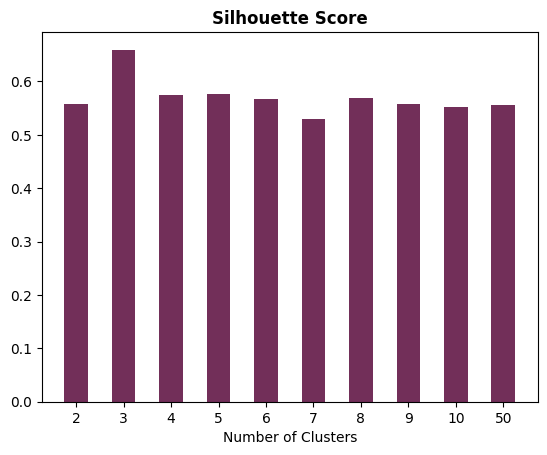

In [33]:
### KMeans clusters

from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

parameters = [2,3,4,5,6,7,8,9,10,50]
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()
silhouette_scores = []

for p in parameter_grid:
  kmeans_model.set_params(**p)
  kmeans_model.fit(pca_2_result)
  ss = silhouette_score(pca_2_result, kmeans_model.labels_)
  silhouette_scores += [ss]
  if ss > best_score:
      best_score = ss
      best_grid = p

plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

3 clusters is best for clustering patients since silhouette score is highest for 3 clusters. Reference -> https://medium.com/swlh/k-means-clustering-on-high-dimensional-data-d2151e1a4240

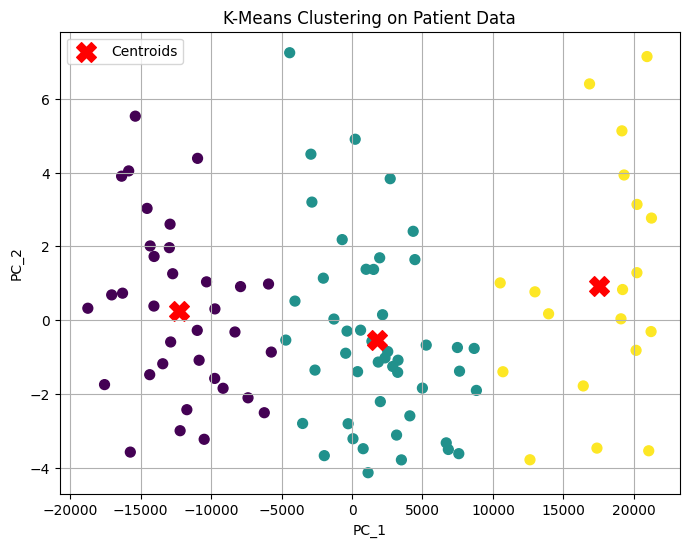

In [45]:
### Applying KMeans using 3 clusters

kmeans = KMeans(n_clusters=3)
kmeans.fit(pca_2_result)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

plt.figure(figsize=(8, 6))
plt.scatter(pca_2_result[:, 0], pca_2_result[:, 1], c=labels, cmap='viridis', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel("PC_1")
plt.ylabel("PC_2")
plt.title("K-Means Clustering on Patient Data")
plt.legend()
plt.grid(True)
plt.show()

In [56]:
### Cluster labels and cluster members
cluster_labels = kmeans.fit_predict(pca_2_result)

cluster_df = pd.DataFrame({
    'subject_id': lab_pivot['subject_id'],  # or lab_pivot['subject_id'] if it's a column
    'cluster': cluster_labels
})

# Group subject_ids by cluster
cluster_groups = cluster_df.groupby('cluster')['subject_id'].apply(list)
# cluster_groups.to_csv('cluster_groups.csv', index=False)